This notebook demonstrates how to use some of the classes and functions in `RomPy` that are used to build reduced-order models and surrogates. This module contains high-level functionality for implementing algorithms commonly used in reduced-order modeling and surrogate building, such as orthonormalization of a set of vectors, building an empirical interpolant from a given set of basis vectors, etc.

In [1]:
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Set font size for plotting
font = {'size':14}
plt.rc('font', **font)

# Import RomPy
import rompy as rp

# Orthonormalization with the iterated, modified Gram-Schmidt procedure

Here, we show how to build an orthonormal set of basis elements from a given set of vectors. The method uses the iterated, modified Gram-Schmidt procedure, which is a version of the Gram-Schmidt procedure that is robust to the accumulation of numerical round-off error from affecting the orthonormalization of a large number of vectors. The algorithm is described by Hoffman in "Iterative Algorithms for Gram-Schmidt Orthogonalization" and is used for building a reduced basis in `RomPy`.

First, let's make some data to orthonormalize, which will just be a set of monomials.

In [2]:
x = np.linspace(-1, 1, num=1001)
vectors = [x**n for n in range(10)]

We'll need an integration rule since Gram-Schmidt requires an inner product to orthonormalize a set of vectors. We'll just use the trapezoidal rule since the monomials are evaluated at equally spaced points. For more on the `Integration` class see the "integration.ipynb" notebook.

In [3]:
integration = rp.Integration([-1, 1], num=len(x), rule='trapezoidal')

Next, we make the basis by creating an instance of the `rp.GramSchmidt` class. Then run `make` as shown below. (Note: The `make` method may be called by default in future versions of `RomPy`.)

In [4]:
gramschmidt = rp.GramSchmidt(vectors, integration)
basis = gramschmidt.make()

We can check that the basis is orthonormal by computing dot products between the elements, which should give us either 1 or 0 (to within numerical round-off error).

In [5]:
for ii in range(len(basis)):
    print("Basis", ii+1, "dot products:\n  ", \
        [integration.dot(basis[ii], basis[jj]) for jj in range(ii, len(basis))])

Basis 1 dot products:
   [1.0, 2.7972416050126014e-17, 1.0443035325380379e-15, 1.6479873021779667e-17, 3.5561831257524545e-17, 1.474514954580286e-17, 1.0842021724855044e-17, 1.3660947373317356e-17, -2.2551405187698492e-17, 3.3393426912553537e-17]
Basis 2 dot products:
   [1.0, -4.141652298894627e-17, -2.2724877535296173e-16, -3.859759734048396e-17, 3.469446951953614e-18, -9.540979117872439e-18, 6.938893903907228e-18, 3.903127820947816e-18, 1.1275702593849246e-17]
Basis 3 dot products:
   [1.0, 1.214306433183765e-17, -2.949029909160572e-17, 6.5052130349130266e-18, -8.673617379884035e-18, 7.806255641895632e-18, 1.734723475976807e-18, -1.1275702593849246e-17]
Basis 4 dot products:
   [1.0, 6.938893903907228e-18, -1.214306433183765e-17, 1.0408340855860843e-17, 1.3877787807814457e-17, -1.734723475976807e-17, -5.204170427930421e-18]
Basis 5 dot products:
   [1.0, -1.0408340855860843e-17, 0.0, -1.3877787807814457e-17, 3.469446951953614e-18, -5.204170427930421e-18]
Basis 6 dot products:
   [0.

Not surprisingly, the basis returned is proportional to the set of Legendre polynomials, $\{P_\ell (x) \}$. The proportionality is given by $\sqrt{\ell+1/2}$, which is the integration weight that appears in Sturm-Liouville theory. Below is a plot of the basis elements (gray) and the fourth Legendre polynomial, $P_4(x)$, in dashed red for comparison. Note that $P_4(x)$ overlays the curve for the fourth basis element.

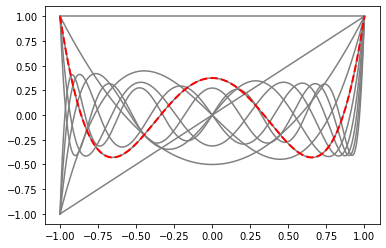

In [6]:
# Plot basis elements divided by sqrt(l+1/2)
[plt.plot(x, basis[ell]/np.sqrt(ell+1./2.), '-', color='gray') for ell in range(len(basis))];

# Plot the fourth Legendre polynomial
from numpy.polynomial.legendre import legval
plt.plot(x, legval(x,[0,0,0,0,1,0,0,0,0,0]), 'r--', linewidth=2);

The elements of the fourth basis (divided by $\sqrt{l+1/2}$) and the fourth Legendre polynomial is given below for comparison. The errors are due to the error incurred in the numerical integrations involved with generating the basis due to the number of samples. Increasing the number of points in the array `x` will give a more accurate comparison.

In [7]:
# Print the fourth basis element (divided by sqrt(l+1/2)) and the fourth Legendre polynomial
print(basis[4]/np.sqrt(4.+0.5))
print(legval(x,[0,0,0,0,1,0,0,0,0,0]))

[0.999945   0.98003559 0.96030533 ... 0.96030533 0.98003559 0.999945  ]
[1.         0.98008986 0.96035888 ... 0.96035888 0.98008986 1.        ]


# Reduced-order surrogate modeling

We next show how to build a reduced-order surrogate model (or "surrogate", for short) 
for Bessel's function of the first kind, $J_\nu(x)$. The end result will be a surrogate that we can evaluate much faster than is done in the `scipy.special` module with little loss in accuracy. 

We show how to do this in two ways
using `RomPy`. The first way, shows most of the detailed steps in the surrogate building
process. The second way, presents a streamlined method to build the same surrogate 
since many of the steps are automatic once a choice or set of choices have been made
(such as, the error measure used to compute the projection error for the reduced basis
greedy algorithm, for instance).

## Step-by-step surrogate building with RomPy

### Build a reduced basis

In this example, we'll show how to build a reduced basis for Bessel's function of the first kind, $J_\nu(x)$. We first define our training set to be parametrized by $\nu \in [0, 100]$ with $1001$ equally spaced points.

In [8]:
nu = np.linspace(0, 100, 1001)

We will take the set of Bessel's functions for each of these values of $\nu$ to be for $x \in [0, 1000]$ with $10,\!001$ equally-spaced samples to constitute the training space of functions. We take the trapezoidal rule for our integration scheme. Of course, other choices can be made in all regards here and the user is encouraged to explore the available options. See the example notebook "integration.ipynb" for further details regarding choices for the integration rules.

In [9]:
from scipy.special import jv as BesselJ

# Make integration rule
integration = rp.Integration([0, 1000], num=10001, rule='trapezoidal')
x = integration.nodes  # Define x for convenience

# NOTE: Generating the training space may take a few minutes
training = np.array([BesselJ(nn, x) for nn in nu])

We can build a reduced basis representation that spans the arrays in the training space by making an instance of the `ReducedBasis` class. This class allocates memory to the arrays the greedy algorithm needs for building the reduced basis. The default options for the `ReducedBasis` class are for building a reduced basis by selecting the most distinct (and thus relevant) values of $\nu$ according to the $L_2$ norm of the difference between the training space functions and their projection onto the current basis elements. See the code  documentation for further information.

In [10]:
rb = rp.ReducedBasis(integration)

To make the reduced basis just use the `make` method. The first argument is the training space that one is finding the reduced basis for. The second argument is the index of the seed value of $\nu$ from the `nu` array that starts the greedy algorithm. The third argument is the error tolerance requested to terminate the greedy algorithm. You can also specify a `num` option for the maximum number of vectors in the output basis.

In [11]:
rb.make(training, 0, 1e-14, verbose=True)

('\nStep', '\t', 'Error')
(1, '\t', 3.04450524606199)
(2, '\t', 2.3705875937219756)
(3, '\t', 1.4509175165554753)
(4, '\t', 1.3595060336944793)
(5, '\t', 1.2738521921178163)
(6, '\t', 1.2124147439423176)
(7, '\t', 1.1818871989422135)
(8, '\t', 1.1547052257564876)
(9, '\t', 1.1097997512331628)
(10, '\t', 1.080383587040988)
(11, '\t', 1.0653116443448676)
(12, '\t', 1.0605880342343141)
(13, '\t', 1.0370363316103308)
(14, '\t', 1.0307219205626077)
(15, '\t', 1.0250221962804753)
(16, '\t', 1.0229860630346008)
(17, '\t', 0.9969434777984764)
(18, '\t', 0.9678386633877869)
(19, '\t', 0.9578866287752045)
(20, '\t', 0.9464450612894024)
(21, '\t', 0.9388256775325751)
(22, '\t', 0.9195085081222446)
(23, '\t', 0.9170538393323608)
(24, '\t', 0.8912274004519056)
(25, '\t', 0.8677437042585567)
(26, '\t', 0.8582195091699923)
(27, '\t', 0.8572130252981489)
(28, '\t', 0.8528638816920898)
(29, '\t', 0.8474930228905397)
(30, '\t', 0.8120167626093219)
(31, '\t', 0.809983139188692)
(32, '\t', 0.8073645564154

The number of vectors in the reduced basis is given by the `size` attribute.

In [12]:
rb.size

74

The $L_2$ norms of the maximum difference between the training space data and its projection onto the current basis, often called the "greedy error" or "representation error", is given below. Note the exponential convergence in the size of the basis after a plateau. This exponential convergence is typical (and expected) of training data with an underlying dependence that is smooth on the parameter (i.e., $\nu$).

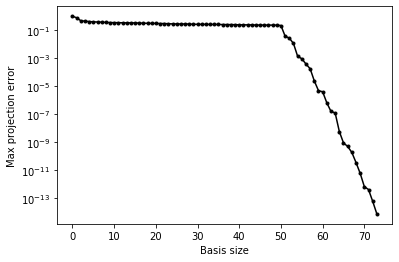

In [13]:
plt.semilogy(rb.errors/rb.errors[0], 'k.-');
plt.xlabel('Basis size')
plt.ylabel('Max projection error')
plt.show()

After running the greedy algorithm, all the information in the training space is represented by $74$ reduced basis elements to within an error of a few parts in $10^{-14}$. This gives a compression of the training space by a factor of $1001/74 \approx 13.5$.

Here's how the $50^{\rm th}$ reduced basis element looks as a function of $x$.

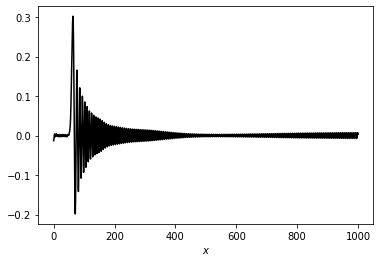

In [14]:
plt.plot(x, rb.basis[50], 'k-')
plt.xlabel('$x$');
plt.show()

The values of $\nu$ selected by the greedy algorithm are shown below with 
the maximum projection error associated with the basis at that corresponding 
size.

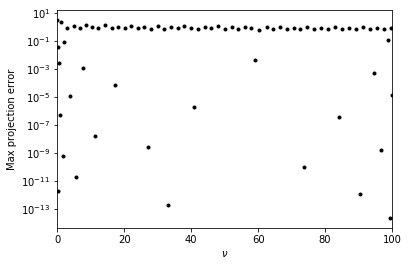

In [15]:
plt.semilogy(nu[rb.indices], rb.errors, 'k.')
plt.xlabel('$\\nu$');
plt.ylabel('Max projection error')
plt.xlim(0, 100);
plt.show()

To gain some intuition about what the greedy algorithm is doing, it is useful to show the complex norm-squared of the quantity $$ ~\\ \alpha_{ij} = \langle e_i , J_{\nu_j} \rangle \\$$ where $i$ indexes the size of the reduced basis (i.e., the number of basis vectors) in the current iteration of the greedy algorithm while $j$ indexes the training space function. The inner product $\langle \cdot, \cdot \rangle$ is measured in the $L_2$ norm. We plot $| \alpha_{ij}|^2$ below. The values of $\nu$ in the training set that give a maximum for $|\alpha_{ij}|^2$ for a given $i$ are what is selected by the greedy algorithm for the next basis element to be included (upon orthonormalizing). Here, $i$ is the iteration number of the greedy algorithm, which increases from top to bottom in the plot.

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


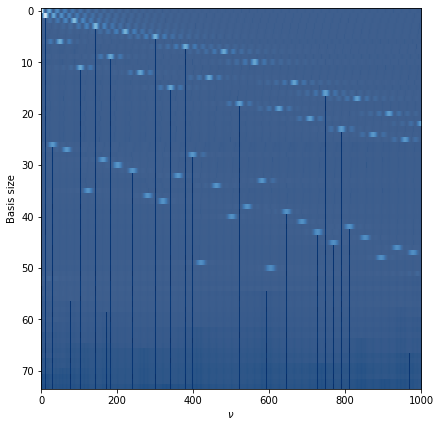

In [16]:
dim_alpha = np.shape(rb.alpha)
fig1 = plt.figure(1, [7,7])
ax1 = fig1.add_subplot(111)
ax1.imshow(np.abs(rb.alpha)**2, aspect=float(dim_alpha[1])/dim_alpha[0], cmap=plt.cm.Blues_r);
ax1.imshow(np.log10(np.abs(rb.alpha)**2), aspect=float(dim_alpha[1])/dim_alpha[0], cmap=plt.cm.Blues_r, alpha=0.25);
plt.xlabel('$\\nu$')
plt.ylabel('Basis size')
plt.show()

Note the dark lines below the white fuzzy dots (which are the maximum values of $|\alpha_{ij}|^2$. These are dark (i.e., very small, near zero) because the inner product of any training space data with the basis is, by construction, going to be near zero. This kind of plot also shows the order in which regions of the training set parameters are selected by the greedy algorithm. By the time $i=50$ comes around the greedy errors begin to decay exponentially with the basis size, which is why the white fuzzy dots seem to "disappear" in the plot. 

Lastly, `rb` contains a `project` method to compute the projection of a given array onto the reduced basis. Let's see how well the reduced basis represents a Bessel's function with $\nu=100$ versus $\nu=110$, outside of the training space, by computing the mismatch with the actual Bessel's function.

In [17]:
print("nu = 100:", integration.mismatch(BesselJ(100., x), rb.project(BesselJ(100., x))))
print("nu = 110:", integration.mismatch(BesselJ(110., x), rb.project(BesselJ(110., x))))

nu = 100: 0.0
nu = 110: 0.19497692427216673


It is clear that the reduced basis does not represent the training data well for parameter values outside of the range used to train the greedy algorithm. However, the greedy algorithm has no information about values of $\nu > 100$ so there should be no expectation for the reduced basis to be useful there. For parameters in the training range, the reduced basis does very well at representing the training data, as seen in the plot below that shows the mismatch errors between the training data and its projections.

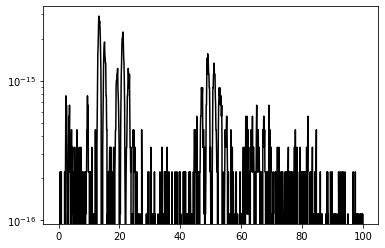

In [18]:
plt.semilogy(nu, [integration.mismatch(tt, rb.project(tt)) for tt in training], 'k-');

One can also generate a random sample of $\nu$ values and corresponding `BesselJ` function evaluations. A good test of the reduced basis is to project the randomly selected data onto the basis and measure its mismatch.

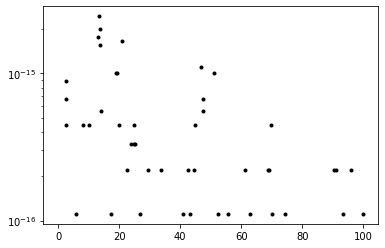

In [19]:
# Generate 100 values of nu and corresponding BesselJ evaluations
nu_random = (np.max(nu)-np.min(nu))*np.random.rand(100) + np.min(nu)
BesselJ_random = np.array([BesselJ(nn, x) for nn in nu_random])

# Plot the mismatches between these and their projections onto the reduced basis
plt.semilogy(nu_random, [integration.mismatch(tt, rb.project(tt)) for tt in BesselJ_random], 'k.');

### Build an empirical interpolant

The reduced basis for Bessel's function of the first kind, which is valid over the training set defined by $\nu \in [0, 100]$, can be interpreted as compressing the $\nu$ dependence of the training space data into a much smaller representation with a loss of accuracy up to numerical round-off errors, essentially, of double-precision floating point arithmetic. 

This data can be further compressed but in $x$ using the Empirical Interpolation method. Empirical interpolation finds the set of $x$ values that "optimally" represents the $x$-dependence of the reduced basis functions. The number of such values is, by construction, equal to the number of reduced elements (i.e., $74$). The resulting empirical interpolant provides a kind of "dual" compression in the $x$-direction that is afforded by the compression in $\nu$ via the reduced basis.

To build an empirical interpolant from the reduced basis we computed earlier for Bessel's function of the first kind we create an instance of the `EmpiricalInterpolant` class, which calls the `make` method by default. Note that only the reduced basis is input.

In [20]:
eim = rp.EmpiricalInterpolant(rb.basis, verbose=True)

('\nStep', '\t', 'Nodes')
(1, '\t', 0)
(2, '\t', 20)
(3, '\t', 104)
(4, '\t', 162)
(5, '\t', 244)
(6, '\t', 324)
(7, '\t', 391)
(8, '\t', 423)
(9, '\t', 509)
(10, '\t', 203)
(11, '\t', 590)
(12, '\t', 475)
(13, '\t', 295)
(14, '\t', 537)
(15, '\t', 697)
(16, '\t', 669)
(17, '\t', 779)
(18, '\t', 864)
(19, '\t', 807)
(20, '\t', 1010)
(21, '\t', 933)
(22, '\t', 736)
(23, '\t', 1050)
(24, '\t', 838)
(25, '\t', 971)
(26, '\t', 1195)
(27, '\t', 47)
(28, '\t', 78)
(29, '\t', 354)
(30, '\t', 756)
(31, '\t', 269)
(32, '\t', 897)
(33, '\t', 1473)
(34, '\t', 633)
(35, '\t', 567)
(36, '\t', 137)
(37, '\t', 449)
(38, '\t', 2665)
(39, '\t', 1132)
(40, '\t', 1072)
(41, '\t', 1718)
(42, '\t', 1319)
(43, '\t', 1379)
(44, '\t', 2031)
(45, '\t', 1666)
(46, '\t', 3745)
(47, '\t', 2116)
(48, '\t', 1260)
(49, '\t', 5647)
(50, '\t', 9985)
(51, '\t', 4174)
(52, '\t', 2780)
(53, '\t', 5853)
(54, '\t', 2)
(55, '\t', 10000)
(56, '\t', 8)
(57, '\t', 183)
(58, '\t', 990)
(59, '\t', 3217)
(60, '\t', 1878)
(61, '\t

Relative to the amount of data contained in the original training space, which is the number of $x$ samples times the number of $\nu$ samples, we find a total compression factor of almost $2,\!000$,

In [21]:
print(float(x.size*nu.size)/(eim.size*rb.size))

1828.15942293645


To use the empirical interpolant to interpolate (actually, to reconstruct) some training data just run the following for the first element, for example, in the training space, $\nu=0$:

In [22]:
print(eim.interpolate(training[0]))
print(training[0])

[1.         0.99750156 0.99002497 ... 0.02523203 0.02513492 0.02478669]
[1.         0.99750156 0.99002497 ... 0.02523203 0.02513492 0.02478669]


The output of the empirical interpolation is accurate essentially to numerical round-off though some error is incurred

In [23]:
# Compute the mismatch between the training data and their empirical interpolation.
eim_max_error = max([integration.mismatch(tt, eim.interpolate(tt)) for tt in training])
print(eim_max_error)

2.6645352591003757e-14


The computational time to evaluate the empirical interpolant on the training data is independent of $\nu$, unlike for `scipy`'s implementation of Bessel's function, and is between about 10 and 100 times faster to evaluate than `scipy`'s implementation.

In [24]:
# Timings for nu = 0
%timeit -n100 -r3 BesselJ(nu[0], x)
%timeit -n100 -r3 eim.interpolate(training[0])

2.75 ms ± 158 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
49.7 µs ± 5.95 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [25]:
# Timings for nu = 100
%timeit -n100 -r3 BesselJ(nu[-1], x)
%timeit -n100 -r3 eim.interpolate(training[-1])

22.8 ms ± 94.3 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
49.6 µs ± 5.59 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


To wrap up this example, we show the values of $\nu$ selected by the reduced basis greedy algorithm with the corresponding values of $x$ that make up the empirical interpolation "nodes." The grid lines are meant to indicate the amount of training information needed to recover any training space data to within the max point-wise error of the empirical interpolation (i.e., $\approx 1.4 \times 10^{-7}$ here).

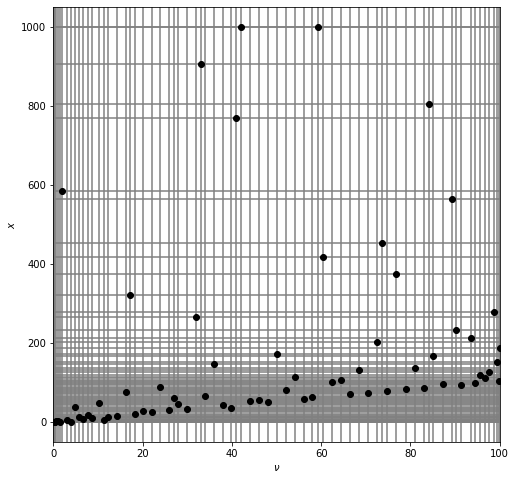

In [26]:
fig2 = plt.figure(2, [8,8])
ax2 = fig2.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in nu[rb.indices]]
[ax2.axhline(y=xx, color='gray') for xx in x[eim.indices]]
ax2.plot(nu[rb.indices], x[eim.indices], 'ko');
ax2.set_xlim(nu.min(), nu.max())
ax2.set_xlabel('$\\nu$');
ax2.set_ylabel('$x$');
plt.show()

Note that more information is needed for $x < 200$ than for $x > 200$ as suggested by the density of grid lines. However, the grid lines are somewhat constant in $\nu$ except near the edges of the training domain, as already found earlier when we built the reduced basis.

Also, if we were to fit for the $\nu$ variation at each of the empirical interpolation nodes than we would have what's called a "surrogate" model for Bessel's function of the first kind that can be evaluated as a substitute (hence, surrogate) for `scipy`'s implementation for any $\nu \in [0, 100]$. Generally speaking, this surrogate paradigm is useful when the time it takes for a code to generate some quantity of interest takes too long, which is determined by the application of interest.

### Build a surrogate

In our last example, we show how to build a surrogate model for the fast and accurate evaluation of Bessel's functions given the reduced basis and empirical interpolation data we constructed above. In the first step, we gather all the (training space) data at the empirical interpolation nodes from which we will estimate the parameter variation at each node by fitting.

In [27]:
eim.make_data(training)

Here's a plot showing the Bessel function amplitudes in the training space at the 11th empirical node.

In [28]:
plt.plot(nu, eim.data[10], 'k.-')
plt.xlabel('$\\nu$');

As we can see from this plot, the data is dense for fitting purposes so we can interpolate using splines. The class `Univariate` is mostly a wrapper to `python` fitting routines but with a uniform way to interact with these functions. Results from the fit, such as fit coefficients and other information, can be accessed from the `_eval` attribute. (Note: The $\nu$ dependence looks very similar to an Airy function.)

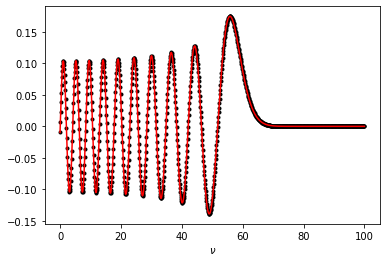

In [29]:
# Spline interpolant of the data at the 11th empirical node
fit = rp.UnivariateFits(nu, eim.data[10], fit='spline', s=0, deg=5)

plt.plot(nu, BesselJ(nu, x[eim.indices[10]]), 'k.')
plt.plot(nu, fit(nu), 'r-')
plt.xlabel('$\\nu$');

As of this writing, more work will be done on the fitting part of the `RomPy` package to be more flexible, user friendly, and provide more types of fits. See the "fits.ipynb" notebook for further details and the current set of available features.

Let's compare the time it takes to evaluate the `BesselJ` function to the time it takes to evaluate the fits made above.

In [34]:
%timeit -n100 -r3 BesselJ(nu, x[eim.indices[10]])
%timeit -n100 -r3 fit(nu)

1.25 ms ± 73.4 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
64.8 µs ± 1.71 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


Let's make fits at all the empirical interpolation nodes. We use 5th degree splines, as before, and collect the interpolants into an array called `fits`.

In [35]:
fits = []
for dd in eim.data:
    fit = rp.UnivariateFits(nu, dd, fit='spline', s=0, deg=5)
    fits.append( fit )

Now that we know how to build a reduced basis, how to construct an empirical interpolant, and how to fit for the parameter variation at the empirical nodes then we can put all these ingredients together to build a reduced-order surrogate model for the fast and accurate evaluation of the `BesselJ` function. We define a function `evalSurrogate` that evaluates the empirical interpolant using the estimates of `BesselJ` by evaluating the fits (that we made earlier) at the requested parameter value. 

In [36]:
# Combine into a surrogate evaluation function
def evalSurrogate(nu):
    # Evaluate the fits at requested nu parameter
    fit_evals = np.array([fits[ii](nu) for ii in range(len(eim.indices))])
    
    # Evaluate the empirical interpolant using the fit evaluations to
    # estimate the BesselJ function at the requested nu parameter
    return np.dot(fit_evals, eim.B)

The resulting reduced-order surrogate model can be evaluated at any $\nu$ in the training set range by calling:

In [37]:
Nu = 94.12
print(evalSurrogate(Nu))

[5.12110421e-18 1.84360823e-17 7.90821287e-18 ... 1.16654196e-02
 9.37694347e-03 6.99583896e-03]


By the eyeball norm the surrogate seems to reproduce the corresponding Bessel function accurately.

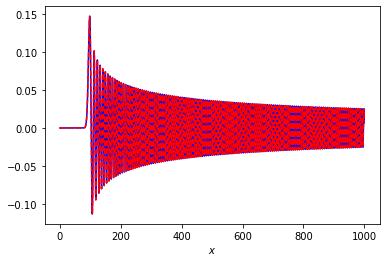

In [38]:
plt.plot(x, BesselJ(Nu, x), 'b-')
plt.plot(x, evalSurrogate(Nu), 'r--')
plt.xlabel('$x$');

Evaluating the surrogate model is faster than calling the `BesselJ` function directly.

In [39]:
%timeit -n100 -r3 evalSurrogate(Nu)
%timeit -n100 -r3 BesselJ(Nu, x)

857 µs ± 198 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
22.7 ms ± 597 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


Lastly, we plot the loss (here, the absolute difference) between the true values of the Bessel function and the surrogate's prediction.

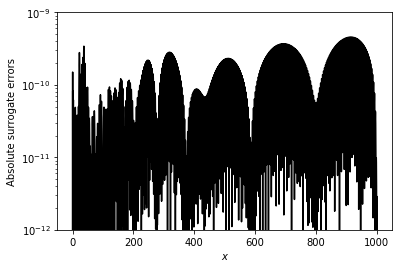

In [40]:
loss = np.abs(BesselJ(Nu, x)-evalSurrogate(Nu))
plt.semilogy(x, loss, 'k-')
plt.ylabel('Absolute surrogate errors')
plt.xlabel('$x$')
plt.ylim(1e-12, 1e-9);

## Streamlined surrogate building with RomPy

To build a standard surrogate model from some training data, all we need to run are the basic commands below.

In [41]:
sur_L2 = rp.Surrogate(integration)

# Build the reduced-order model (i.e., reduced basis + empirical interpolant) 
# using the L2 loss function for computing projection errors
sur_L2.MakeROM(training, 0, 1e-12)  
print("Basis size =", sur_L2.rb.size)

# Fit empirical node data to (default) 5th degree, non-smoothing splines (s=0)
sur_L2.MakeFits(nu, fit='spline', deg=5)  

Basis size = 72


Here's a different surrogate that uses the $L_\infty$ loss function to compute the errors between the training space data and their projections onto the basis. Note that this loss function chooses the reduced data based on the maximum point-wise difference between the training set and their projections, which is thus more stringent than the $L_2$ loss function since the latter is related to averaging the point-wise difference.

In [43]:
sur_Linfty = rp.Surrogate(integration)

# Build the reduced-order model (i.e., reduced basis + empirical interpolant) 
# using the L-infinity loss function for computing projection errors
sur_Linfty.MakeROM(training, 0, 1e-12, loss='Linfty')
print("Basis size =", sur_Linfty.rb.size)

# Fit empirical node data to (default) 5th degree, non-smoothing splines (s=0)
sur_Linfty.MakeFits(nu, fit='spline', deg=5)  

Basis size = 86


To evaluate the surrogates we can simply make the two equivalent calls below for the $L_\infty$ model, for instance:

In [44]:
print(sur_Linfty.Eval(Nu))  # First way uses the Eval method
print(sur_Linfty(Nu))       # Second uses the __call__ method, which just runs the Eval method

[-1.15699501e-17 -2.99341703e-19 -2.07438655e-18 ...  1.16654196e-02
  9.37694347e-03  6.99583896e-03]
[-1.15699501e-17 -2.99341703e-19 -2.07438655e-18 ...  1.16654196e-02
  9.37694347e-03  6.99583896e-03]


We can test both surrogates by comparing their predictions at $\nu$ values not used for building the models. We see that the $L_2$-based surrogate generally does somewhat worse -- though still very accurate -- compared to the $L_\infty$-based model. The reason is because the $L_2$ measure used for evaluating the reduced basis projection errors in the greedy algorithm are (loosely) the squares of the $L_\infty$ measure. So a greedy tolerance for the $L_2$ case is only accurate, in a point-wise sense, to about the square root of the greedy tolerance, which is $\sqrt{10^{-12}} = 10^{-6}$, which is roughly what we see in the plot below (the blue curve).

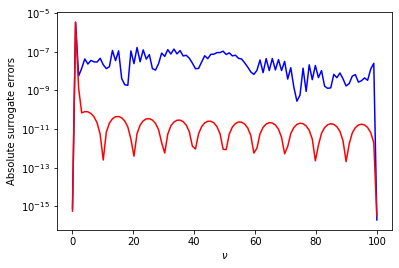

In [45]:
nus = np.linspace(nu.min(), nu.max(), 100)

plt.semilogy(nus, [integration.Linfty(BesselJ(nn, x)-sur_L2(nn)) for nn in nus], 'b-')
plt.semilogy(nus, [integration.Linfty(BesselJ(nn, x)-sur_Linfty(nn)) for nn in nus], 'r-')
plt.ylabel('Absolute surrogate errors')
plt.xlabel('$\\nu$');

However, notice that the Bessel function is predicted rather poorly for small values of $\nu$ for both surrogates. What's going on? Inspection of the training data variation with $\nu$ at the first empirical node (which is at $x=0$) reveals that the data is non-zero only at $\nu=1$. 

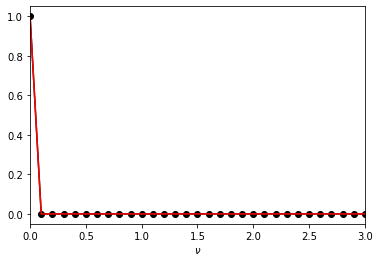

In [46]:
ind = 0
plt.plot(nu, sur_L2.ei.data[ind], 'ko-')
plt.plot(nu, sur_L2.fits._eval[ind](nu), 'r-')
plt.xlabel('$\\nu$');
plt.xlim(0,3);  # Zoom-in to near nu=0 to see the discontinuity better

This non-smooth feature will not be accurately captured by a spline interpolant. Since we know what the behavior should be we simply construct a function that is $1$ at the origin and $0$ elsewhere and use this to replace the first entry in the lists of the fitting functions, which are `sur_L2.fits._eval` and `sur_Linfty.fits._eval`.

In [47]:
def delta(x):
    """Delta function centered at x=0"""
    return 1. * (x == 0)

sur_L2.fits._eval[0] = delta
sur_Linfty.fits._eval[0] = delta

Recomputing the errors above we find much better behavior for small $\nu$. 

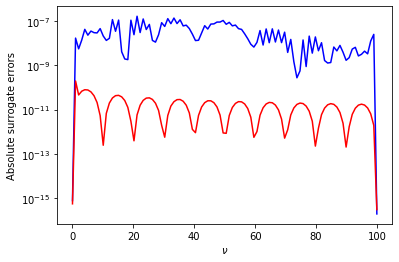

In [48]:
nus = np.linspace(nu.min(), nu.max(), 100)

plt.semilogy(nus, [integration.Linfty(BesselJ(nn, x)-sur_L2(nn)) for nn in nus], 'b-')
plt.semilogy(nus, [integration.Linfty(BesselJ(nn, x)-sur_Linfty(nn)) for nn in nus], 'r-')
plt.ylabel('Absolute surrogate errors')
plt.xlabel('$\\nu$');

In [49]:
%timeit -n100 -r3 BesselJ(Nu, x)
%timeit -n100 -r3 sur_L2(Nu)
%timeit -n100 -r3 sur_Linfty(Nu)

22.9 ms ± 543 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
644 µs ± 11.8 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
828 µs ± 54.1 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
